## Imports

In [40]:
import os
import sys
import glob
import logging

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    Transform,
    Resize,
    CenterSpatialCrop,
    AdjustContrast
)

from monai.data import CacheDataset, DataLoader
from monai.visualize import matshow3d
from monai.utils import first, set_determinism
from monai.apps import get_logger

## Determinism, device and logger

In [36]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA TITAN RTX


In [41]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
get_logger('train_log')
set_determinism(0)
device = torch.device('cuda:0')

In [42]:
torch.cuda.empty_cache()
torch.cuda.memory_stats()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

## Load and prepare dataset

In [19]:
image_size = 256
num_slices = 128
contrast_gamma = 1.5
batch_size = 1
every_n_slice = 8

In [31]:
data_dir = '/data1/dose-3d-generative/data_med/PREPARED/FOR_AUG'
directory = os.path.join(data_dir, 'ct_images')
images_pattern = os.path.join(directory, '*.nii.gz')
images = sorted(glob.glob(images_pattern))[:3]

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        CenterSpatialCrop((400, 400, 0)),
        Resize((image_size, image_size, num_slices)),
        ScaleIntensity(),
        AdjustContrast(contrast_gamma),
        RandRotate(range_x=np.pi/12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType()
    ]
)

dataset = CacheDataset(images, train_transforms)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          num_workers=10, shuffle=True,
                                          pin_memory=torch.cuda.is_available())

Loading dataset: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


(1, 1, 256, 256, 128)


(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

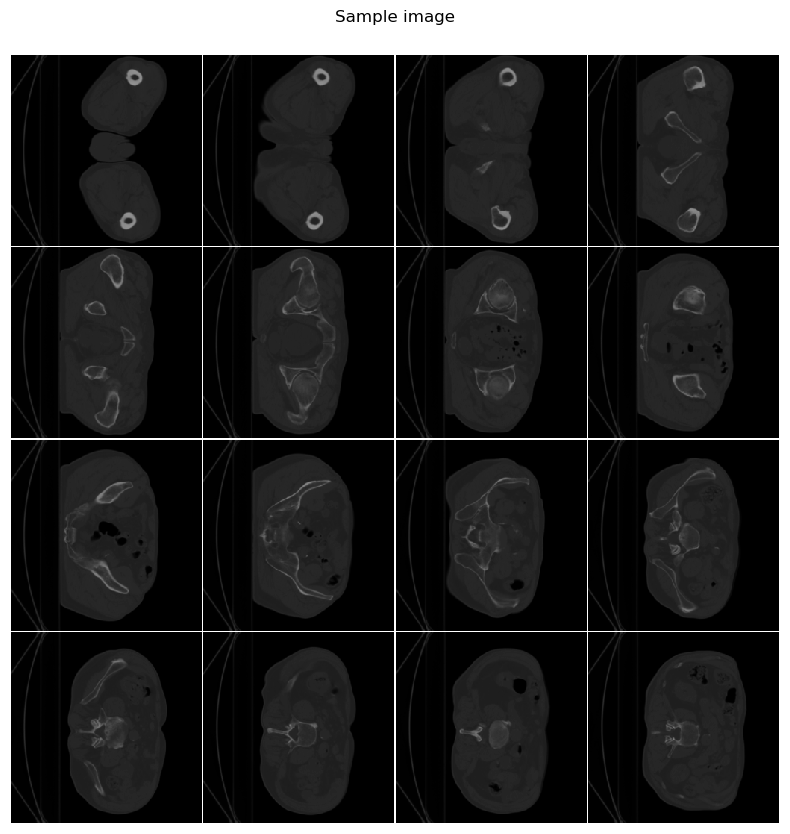

In [32]:
image_sample = first(loader)
print(image_sample.shape)

fig = plt.figure(figsize=(15,15))
matshow3d(volume=image_sample,
          fig=fig,
          title="Sample image",
          every_n=every_n_slice,
          frame_dim=-1,
          cmap="gray")

## Define model and hyperparameters

In [ ]:
def Critic(nn.Module):
    pass

def Generator(nn.Module):
    pass